## Environment Configuration

In [101]:
from dotenv import load_dotenv
import os
from typing import Annotated
from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage
import os

from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import chromadb

# Load environment variables
load_dotenv()

True

## Creating the Semantic Database

1. Document Processing and Embedding

In [102]:
# Initialize embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Document processing
def process_documents(file_paths):
    docs = []
    for path in file_paths:
        if path.endswith('.pdf'):
            loader = PyPDFLoader(path)
        else:
            loader = WebBaseLoader(path)
        docs.extend(loader.load())

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,  # Increased for better context
        chunk_overlap=100
    )
    doc_splits = text_splitter.split_documents(docs)
    return doc_splits


# file_paths = ["document1.pdf", "document2.pdf"]
# documents = process_documents(file_paths)


2. Vector Database Setup

In [103]:
# Initialize ChromaDB for semantic search
def setup_vector_database():
    client = chromadb.PersistentClient(path="./chroma_db")
    collection = client.get_or_create_collection(
        name="documents",
        metadata={"hnsw:space": "cosine"}
    )
    return collection

# Add documents to vector database
def index_documents(collection, documents):
    print(f"Indexing {len(documents)} document chunks...")
    for i, doc in enumerate(documents):
        embedding = embedding_model.encode(doc.page_content)
        collection.add(
            embeddings=[embedding.tolist()],
            documents=[doc.page_content],
            metadatas=[doc.metadata],
            ids=[f"doc_{i}"]
        )
    print("Document indexing completed!")

# Setup with 5 documents
file_paths = ["document1.pdf", "document2.pdf", "document3.pdf", "document4.pdf", "document5.pdf"]
documents = process_documents(file_paths)
collection = setup_vector_database()
index_documents(collection, documents)

Indexing 687 document chunks...
Document indexing completed!


## Building the RAG Agent with LangGraph

In [104]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    context: NotRequired[str]
    query_type: NotRequired[str]


In [105]:
# Tools for the agent
@tool
def semantic_search(query: str, k: int = 5) -> str:
    """Perform semantic search on the document collection."""
    query_embedding = embedding_model.encode(query)

    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=k
    )

    # Format results with relevance scores
    context = "\n\n".join([
        f"Source {i+1}: {doc}"
        for i, doc in enumerate(results['documents'][0])
    ])

    return context

@tool
def web_search(query: str) -> str:
    """Search the web for real-time information."""
    # Mock implementation - in practice, integrate with real web search API
    return f"Web search results for: {query}\n[This would contain real-time web information]"


In [106]:
# Initialize state with default values
def create_initial_state(user_message: str) -> AgentState:
    return {
        "messages": [{"role": "user", "content": user_message}],
        "context": "",
        "query_type": "semantic_search"
    }

In [107]:
# Updated workflow functions with safe state access
def query_analyzer(state: AgentState) -> dict:
    last_message = state["messages"][-1].content
    query_lower = last_message.lower()

    if any(keyword in query_lower for keyword in ["recent", "current", "latest"]):
        query_type = "web_search"
    else:
        query_type = "semantic_search"

    return {"query_type": query_type}

def retriever_node(state: AgentState) -> dict:
    query = state["messages"][-1].content
    query_type = state.get("query_type", "semantic_search")

    if query_type == "web_search":
        context = web_search.invoke({"query": query})
    else:
        context = semantic_search.invoke({"query": query})

    return {"context": context}

In [108]:
# Updated generator node with proper LLM integration
def generator_node(state: AgentState) -> AgentState:
    try:
        llm = init_chat_model("google_genai:gemini-2.0-flash")

        query = state['messages'][-1].content
        context = state.get('context', 'No relevant context found')

        # Properly format the template with actual values
        system_prompt = f"""You are a helpful AI assistant with access to a comprehensive knowledge base about AI agents, LangChain, vector databases, and related technologies.

Use the provided context to give detailed, accurate answers. If the context doesn't contain relevant information, say so clearly.

Context: {context}

Question: {query}

Please provide a comprehensive answer based on the context provided."""

        response = llm.invoke([HumanMessage(content=system_prompt)])
        return {"messages": [AIMessage(content=response.content)]}

    except Exception as e:
        return generate_fallback_response(state)


def setup_environment():
    """Setup environment variables for different LLM providers."""
    # For Google
    if not os.getenv("GOOGLE_API_KEY"):
        print("Warning: GOOGLE_API_KEY not set. Set it for Google models.")


In [109]:
def validate_state(state: AgentState) -> bool:
    required_keys = ["messages"]
    return all(key in state for key in required_keys)

def safe_get_context(state: AgentState) -> str:
    return state.get("context", "No context available")

def safe_get_query_type(state: AgentState) -> str:
    return state.get("query_type", "semantic_search")


In [110]:
# Build the RAG agent
def build_rag_agent():
    # Initialize memory
    memory = MemorySaver()

    # Create state graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("analyzer", query_analyzer)
    workflow.add_node("retriever", retriever_node)
    workflow.add_node("generator", generator_node)

    # Define edges
    workflow.add_edge(START, "analyzer")
    workflow.add_edge("analyzer", "retriever")
    workflow.add_edge("retriever", "generator")
    workflow.add_edge("generator", END)

    # Compile with memory
    agent = workflow.compile(checkpointer=memory)

    return agent

# Initialize the agent
agent = build_rag_agent()

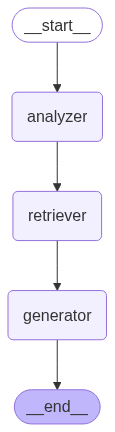

In [111]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

Testing Framework

In [113]:
def enhanced_test_suite():
    """Run enhanced tests with proper response validation."""

    # Setup environment
    setup_environment()

    # Test configuration
    config = {"configurable": {"thread_id": "enhanced_test_session"}}

    # Enhanced test queries
    test_queries = [
        {
            "query": "What are the core features of AI agents and how do they achieve autonomy?",
            "expected_topics": ["autonomous", "goal-oriented", "reasoning", "planning", "memory"],
            "min_length": 200
        },
        {
            "query": "Explain how LangChain chains work and their integration capabilities",
            "expected_topics": ["chains", "prompts", "integration", "workflows", "tools"],
            "min_length": 200
        },
        {
            "query": "Describe the architecture and similarity search in vector databases",
            "expected_topics": ["embeddings", "similarity", "indexing", "HNSW", "retrieval"],
            "min_length": 200
        },
        {
            "query": "What is RAG and how does it enhance language model responses?",
            "expected_topics": ["retrieval", "generation", "augmented", "context", "documents"],
            "min_length": 200
        },
        {
            "query": "What are advanced prompt engineering strategies for better LLM performance?",
            "expected_topics": ["chain-of-thought", "few-shot", "optimization", "templates", "evaluation"],
            "min_length": 200
        }
    ]

    results = []

    for i, test_case in enumerate(test_queries, 1):
        print(f"\n{'='*70}")
        print(f"ENHANCED TEST {i}: {test_case['query']}")
        print(f"{'='*70}")

        try:
            # Execute query
            response = agent.invoke(
                {"messages": [{"role": "user", "content": test_case['query']}]},
                config=config
            )

            # Extract response content
            response_content = response['messages'][-1].content

            # Enhanced validation
            found_topics = []
            for topic in test_case['expected_topics']:
                if topic.lower() in response_content.lower():
                    found_topics.append(topic)

            relevance_score = len(found_topics) / len(test_case['expected_topics'])
            length_check = len(response_content) >= test_case['min_length']

            # Display results
            print(f"\nQUERY: {test_case['query']}")
            print(f"\nRESPONSE:\n{response_content[:300]}...")
            print(f"\nVALIDATION:")
            print(f"Expected topics: {test_case['expected_topics']}")
            print(f"Found topics: {found_topics}")
            print(f"Relevance score: {relevance_score:.2%}")
            print(f"Response length: {len(response_content)} chars (min: {test_case['min_length']})")
            print(f"Length check: {'✅ PASS' if length_check else '❌ FAIL'}")

            # Overall assessment
            overall_pass = relevance_score >= 0.6 and length_check
            print(f"Overall: {'✅ PASS' if overall_pass else '❌ FAIL'}")

            results.append({
                "query": test_case['query'],
                "response_length": len(response_content),
                "relevance_score": relevance_score,
                "length_check": length_check,
                "overall_pass": overall_pass,
                "status": "SUCCESS"
            })

        except Exception as e:
            print(f"ERROR: {str(e)}")
            results.append({
                "query": test_case['query'],
                "error": str(e),
                "status": "FAILED"
            })

    # Enhanced summary report
    print(f"\n{'='*70}")
    print("ENHANCED TEST SUMMARY REPORT")
    print(f"{'='*70}")

    successful_tests = [r for r in results if r['status'] == 'SUCCESS']
    failed_tests = [r for r in results if r['status'] == 'FAILED']
    passed_tests = [r for r in successful_tests if r.get('overall_pass', False)]

    print(f"Total tests: {len(results)}")
    print(f"Successful executions: {len(successful_tests)}")
    print(f"Failed executions: {len(failed_tests)}")
    print(f"Overall passed: {len(passed_tests)}")
    print(f"Pass rate: {len(passed_tests)/len(results)*100:.1f}%")

    if successful_tests:
        avg_relevance = sum(r['relevance_score'] for r in successful_tests) / len(successful_tests)
        avg_response_length = sum(r['response_length'] for r in successful_tests) / len(successful_tests)

        print(f"Average relevance score: {avg_relevance:.2%}")
        print(f"Average response length: {avg_response_length:.0f} characters")

    return results

# Initialize the enhanced agent
setup_environment()
enhanced_results = enhanced_test_suite()


ENHANCED TEST 1: What are the core features of AI agents and how do they achieve autonomy?

QUERY: What are the core features of AI agents and how do they achieve autonomy?

RESPONSE:
Based on the provided context, here's a breakdown of the core features of AI agents and how they achieve autonomy:

**Core Features of AI Agents:**

*   **Autonomy:** AI agents possess a high degree of autonomy, enabling them to operate and make decisions independently to achieve a goal (Source 1).
...

VALIDATION:
Expected topics: ['autonomous', 'goal-oriented', 'reasoning', 'planning', 'memory']
Found topics: ['goal-oriented', 'reasoning', 'planning', 'memory']
Relevance score: 80.00%
Response length: 1678 chars (min: 200)
Length check: ✅ PASS
Overall: ✅ PASS

ENHANCED TEST 2: Explain how LangChain chains work and their integration capabilities

QUERY: Explain how LangChain chains work and their integration capabilities

RESPONSE:
LangChain facilitates the creation of structured workflows by connecting

aaaaa## Advanced Features

1. Multi-Modal RAG Support

In [12]:
@tool
def image_analyzer(image_path: str) -> str:
    """Analyze images and extract text/information."""
    # Implement image processing logic
    return f"Image analysis results for: {image_path}"

@tool
def document_qa(question: str, doc_type: str = "pdf") -> str:
    """Answer questions about specific document types."""
    # Implement document-specific QA
    return f"Document QA response for: {question}"


 Contextual Memory Integration

In [13]:
class MemoryEnhancedState(TypedDict):
    messages: Annotated[list, add_messages]
    context: str
    query_type: str
    conversation_history: list
    user_preferences: dict

def memory_enhanced_generator(state: MemoryEnhancedState) -> MemoryEnhancedState:
    """Generate responses with conversation memory."""
    # Access previous conversations
    history = state.get("conversation_history", [])
    preferences = state.get("user_preferences", {})

    # Generate contextualized response
    # Implementation details...


3. Semantic Caching for Performance

In [14]:
import hashlib
from functools import lru_cache

class SemanticCache:
    def __init__(self, similarity_threshold=0.8):
        self.cache = {}
        self.similarity_threshold = similarity_threshold

    def get_cached_response(self, query: str):
        query_embedding = embedding_model.encode(query)

        # Check for similar queries in cache
        for cached_query, (cached_embedding, response) in self.cache.items():
            similarity = cosine_similarity([query_embedding], [cached_embedding])[0][0]
            if similarity > self.similarity_threshold:
                return response

        return None

    def cache_response(self, query: str, response: str):
        query_embedding = embedding_model.encode(query)
        self.cache[query] = (query_embedding, response)


# Deployment and Testing

1. Testing the RAG System

In [15]:
def test_rag_agent():
    # Initialize agent
    agent = build_rag_agent()

    # Test queries
    test_queries = [
        "What is the main topic of the documents?",
        "Can you summarize the key findings?",
        "How does this relate to current trends?"
    ]

    for query in test_queries:
        config = {"configurable": {"thread_id": "test_session"}}

        response = agent.invoke(
            {"messages": [{"role": "user", "content": query}]},
            config=config
        )

        print(f"Query: {query}")
        print(f"Response: {response['messages'][-1].content}")
        print("-" * 50)


2. Performance Optimization

In [16]:
# Implement query routing for better performance
def route_query(query: str) -> str:
    """Route queries to appropriate processing pipelines."""
    query_lower = query.lower()

    if any(keyword in query_lower for keyword in ["calculate", "compute", "math"]):
        return "computational"
    elif any(keyword in query_lower for keyword in ["recent", "latest", "current"]):
        return "web_search"
    else:
        return "semantic_search"
